# Sentiment Analysis using Airline Tweets
Author: Matthew Huh

## Introduction

Social media is a treasure trove of textual data. It’s a free and easy way for users to express themselves and share whatever they want to say, get attention, and even start movements. 

It’s a powerful way for companies to get an idea of what users think about them, understand how their brands may be perceived, and identify ways to improve business by analyzing the concerns that users have with their products or services. And that is what I aim to accomplish in this project, by analyzing mentions of a few airlines and determining how people perceive their options, and evaluate what concerns people are mentioning. 


## About the Data

The data for this project has been obtained from two sources. The first data set is a collection of data pre-compiled from crowdflower, and is freely available on Kaggle. The second data set has been obtained using Twitter’s API (tweepy to be precise) 

The first data set has far more information as the data has been reviewed by people to determine the sentiment, and the rationale behind negative comments. The tweets have been evaluated by people and for the sake of simplicity, we will be assuming that those results are correct. The data set contains data from February 2015 and only mentions 6 different airlines ('American', 'Delta', 'Southwest', 'US Airways', 'United', 'Virgin America'). 

Our second data set is more recent, November 2018, and has both the same airlines in our training set, but also a few more airlines that aren’t. This is done in order to introduce data that we haven’t trained with yet. In theory, the models developed in this project should be able to do just that.

## Research Question

How accurate of a model can we build to determine a tweet's sentiment?


## Sources


https://www.kaggle.com/crowdflower/twitter-airline-sentiment (Pre-compiled Kaggle data)


http://nbviewer.jupyter.org/github/mhuh22/Thinkful/blob/master/Bootcamp/Unit%207/Twitter%20API%20%40Airline%20Tweets.ipynb (Tweepy Script)


## To-do list

### Necessary
* Profread, and add the text (Yes, this is intentional)
* Implement NLP methods (LSA, LDA, NNMF)


* Implement clustering methods to tweets


* Done: Run machine learning models
* Todo: Optimize machine learning models

### Small Things

* Remove @mentions
* Change max_words parameter for tf-idf later
(
150 = 73%
600 = 77%
6000 is max)


### Optional
* Done: Extract twitter data for testing data set (sort of)
* Todo: Extract more data? (Is 18,000 possible?)

<div class="alert alert-block alert-warning">
Note: The visuals for this project do not render correctly on Github; if you would like to view the presentation the way it was meant to be viewed, please click on the following link.

http://nbviewer.jupyter.org/github/mhuh22/Thinkful/blob/master/Bootcamp/Unit%207/Sentiment%20Analysis%20using%20Airline%20Tweets.ipynb
</div>

## Packages

In [1]:
# Necessary imports
import os
import time
import timeit
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
%matplotlib inline

# Modelling packages
from sklearn import ensemble
from sklearn.feature_selection import chi2, f_classif, SelectKBest 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize

# Natural Language processing
import nltk
import re
import spacy
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_rcv1
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# Clustering packages
import sklearn.cluster as cluster
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from scipy.spatial.distance import cdist

# Plotly packages
import cufflinks as cf
import ipywidgets as widgets
import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools
from scipy import special
py.offline.init_notebook_mode(connected=True)

C:\Users\mhuh22\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Import the data
tweets = pd.read_csv("airline_tweets/Tweets.csv")

# Preview the dataset
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
# View the columns / dtypes in our dataset
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [4]:
# View the size of the dataset
tweets.shape

(14640, 15)

This dataset has a bit more information than we actually need for this project. We definitely need the text information since that is what we are evaluating, the sentiment since that is what we are trying to measure, and the reason to determine what clusters of complaints people are encountering. As for the rest, they could have some impact on the outcome, but they are not what we are trying to measure so, we'll drop the rest before continuing in order to improve our runtimes.

In [5]:
# Drop columns that have no predictive power
tweets.drop(['tweet_id'], axis=1,inplace=True)

In [6]:
# Print unique airlines in the dataset
sorted(tweets['airline'].unique())

['American', 'Delta', 'Southwest', 'US Airways', 'United', 'Virgin America']

In [7]:
# Describe unique occurences for each categorical variable
tweets.select_dtypes(include=['object']).nunique()

airline_sentiment             3
negativereason               10
airline                       6
airline_sentiment_gold        3
name                       7701
negativereason_gold          13
text                      14427
tweet_coord                 832
tweet_created             14247
tweet_location             3081
user_timezone                85
dtype: int64

## Data Visualization

In [8]:
# View distribution of tweets by sentiment 
# (Changing colors to red/gray/green would be nice)
trace = go.Pie(labels=tweets['airline_sentiment'].value_counts().index, 
              values=tweets['airline_sentiment'].value_counts())

# Create the layout
layout = go.Layout(
    title = 'Tweet Sentiment',
    height = 400,
    width = 500,
    autosize = False,
    yaxis = dict(title='Number of tweets')
)

fig = go.Figure(data = [trace], layout = layout)
py.offline.iplot(fig, filename='cufflinks/simple')

In [9]:
# Plots the complaint reasons, and their frequency
# (It might be nice to somehow show how common each reason is for each airline)

# The input is the number of negative tweets by reason
data = [go.Bar(
    x = tweets.negativereason.value_counts().index,
    y = tweets.negativereason.value_counts(),
    opacity = 0.7
)]

# Create the layout
layout = go.Layout(
    title = 'Negative Tweets by Reason',
    yaxis = dict(title='Number of tweets')
)

fig = go.Figure(data = data, layout = layout)
py.offline.iplot(fig, filename='cufflinks/simple')

In [10]:
# Show distribution of texts

trace1 = go.Bar(
    x = sorted(tweets['airline'].unique()),
    y = tweets[tweets['airline_sentiment'] == 'negative'].groupby('airline')['airline_sentiment'].value_counts(),
    name = 'Negative',
    marker = dict(color='rgba(200,0,0,.7)')
)

trace2 = go.Bar(
    x = sorted(tweets['airline'].unique()),
    y = tweets[tweets['airline_sentiment'] == 'neutral'].groupby('airline')['airline_sentiment'].value_counts(),
    name = 'Neutral',
    marker = dict(color='rgba(150,150,150,.7)')
)

trace3 = go.Bar(
    x = sorted(tweets['airline'].unique()),
    y = tweets[tweets['airline_sentiment'] == 'positive'].groupby('airline')['airline_sentiment'].value_counts(),
    name = 'Positive',
    marker = dict(color='rgba(0,200,0,.7)')
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title = 'Airline Sentiment (Total Tweets)',
    barmode='group',
    yaxis = dict(title='Number of tweets')
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig, filename='stacked-bar')

<div class="alert alert-block alert-warning">
For the above visual, please feel free to toggle the sentiment categories on the right.
</div>

### Class Imbalance

Based on the number of total tweets above, we can see that certain airlines don't have the same presence as others, namely Virgin America, which is a much smaller airline than the others in our dataset. In order to fix this issue, I will be upsampling the data so that all of the airlines will have an equal number of tweets.

In [11]:
# Count # of tweets for each airline
tweets.groupby(['airline']).size().sort_values(ascending = False)

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
dtype: int64

In [12]:
# Create temporary dataframe for all airlines to upsample and concatenate
tweets_united = tweets[tweets.airline=='United']
sample_size = len(tweets[tweets['airline']=='United'])

# Upsample all other airlines
tweets_usairways = resample(tweets[tweets.airline=='US Airways'], 
                            replace=True, n_samples=sample_size)
tweets_american = resample(tweets[tweets.airline=='American'], 
                           replace=True, n_samples=sample_size)
tweets_southwest = resample(tweets[tweets.airline=='Southwest'], 
                            replace=True, n_samples=sample_size)
tweets_delta = resample(tweets[tweets.airline=='Delta'], 
                        replace=True, n_samples=sample_size)
tweets_virgin = resample(tweets[tweets.airline=='Virgin America'], 
                         replace=True, n_samples=sample_size)

# Concatenate the individual dataframes
tweets = pd.concat([tweets_united, 
                   tweets_usairways, 
                   tweets_american, 
                   tweets_southwest,
                   tweets_delta,
                   tweets_virgin])

tweets = tweets.reset_index(drop=True)

# Count # of tweets for each airline to verify
tweets.groupby(['airline']).size()

airline
American          3822
Delta             3822
Southwest         3822
US Airways        3822
United            3822
Virgin America    3822
dtype: int64

In [13]:
# Show distribution of texts

trace1 = go.Bar(
    x = sorted(tweets['airline'].unique()),
    y = (tweets[tweets['airline_sentiment'] == 'negative'].groupby('airline')['airline_sentiment'].value_counts().values) / (tweets['airline'].value_counts().sort_index().values),
    name = 'Negative',
    marker = dict(color='rgba(200,0,0,.7)')
)

trace2 = go.Bar(
    x = sorted(tweets['airline'].unique()),
    y = (tweets[tweets['airline_sentiment'] == 'neutral'].groupby('airline')['airline_sentiment'].value_counts().values) / (tweets['airline'].value_counts().sort_index().values),
    name = 'Neutral',
    marker = dict(color='rgba(150,150,150,.7)')
)

trace3 = go.Bar(
    x = sorted(tweets['airline'].unique()),
    y = (tweets[tweets['airline_sentiment'] == 'positive'].groupby('airline')['airline_sentiment'].value_counts().values) / (tweets['airline'].value_counts().sort_index().values),
    name = 'Positive',
    marker = dict(color='rgba(0,200,0,.7)')
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title = 'Airline Sentiment (Percentage)',
    barmode='group',
    yaxis = dict(title='% of tweets')
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig, filename='stacked-bar')

<div class="alert alert-block alert-warning">
For the above visual, please feel free to toggle the sentiment categories on the right.
</div>

## Text Cleaning

In [14]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [15]:
# Remove non-essential punctuation from the tweets
pd.options.display.max_colwidth = 200
tweets['text'] = tweets['text'].map(lambda x: text_cleaner(str(x)))
tweets['text'].head()

0                                                                                                                                @united thanks
1                                                                                   @united Thanks for taking care of that MR!! Happy customer.
2      @united still no refund or word via DM. Please resolve this issue as your Cancelled Flightled flight was useless to my assistant's trip.
3    @united Delayed due to lack of crew and now delayed again because there's a long line for deicing... Still need to improve service #united
4                                                                      @united thanks we filled it out. How's our luck with this? Is it common?
Name: text, dtype: object

In [16]:
# Reduce all text to their lemmas
lemmatizer = WordNetLemmatizer()

for tweet in tweets['text']:
    tweet = lemmatizer.lemmatize(tweet)

In [17]:
# Modify values of sentiment to numerical values
sentiment = {'negative': -1, 'neutral': 0, 'positive': 1}
tweets['airline_sentiment'] = tweets['airline_sentiment'].map(lambda x: sentiment[x])

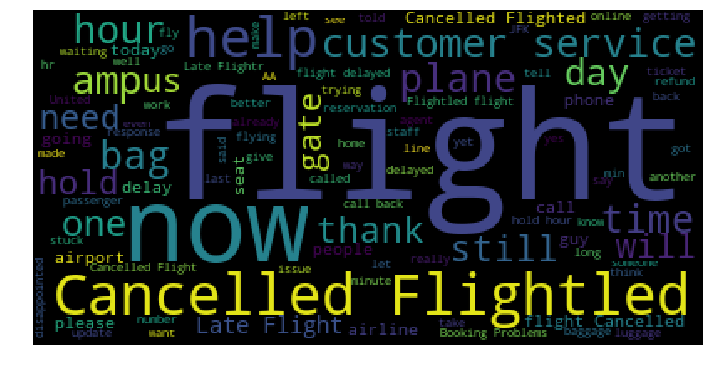

In [18]:
# Modify later; 
# (there are a lot of non-descript filler words like flight)
# (Maybe add a wordcloud for positive tweets?)

df=tweets[tweets['airline_sentiment']==-1]
words = ' '.join(df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      max_words = 100
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Natural Lanuage Processing

In [19]:
X = tweets['text']
y = tweets['airline_sentiment']

In [20]:
# # Instantiating spaCy
# nlp = spacy.load('en')
# X_words = []

# for row in X:
#     # Processing each row for tokens
#     row_doc = nlp(row)
#     # Calculating length of each sentence
#     sent_len = len(row_doc) 
#     # Initializing counts of different parts of speech
#     advs = 0
#     verb = 0
#     noun = 0
#     adj = 0
#     for token in row_doc:
#         # Identifying each part of speech and adding to counts
#         if token.pos_ == 'ADV':
#             advs +=1
#         elif token.pos_ == 'VERB':
#             verb +=1
#         elif token.pos_ == 'NOUN':
#             noun +=1
#         elif token.pos_ == 'ADJ':
#             adj +=1
#     # Creating a list of all features for each sentence
#     X_words.append([row_doc, advs, verb, noun, adj, sent_len])

# # Create dataframe with count of adverbs, verbs, nouns, and adjectives
# X_count = pd.DataFrame(data=X_words, columns=['BOW', 'ADV', 'VERB', 'NOUN', 'ADJ', 'sent_length'])

# # Change token count to token percentage
# for column in X_count.columns[1:5]:
#     X_count[column] = X_count[column] / X_count['sent_length']

# # Normalize X_count
# X_counter = normalize(X_count.drop('BOW',axis=1))
# X_counter  = pd.DataFrame(data=X_counter)

In [21]:
# Parameters for TF-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=3, 
                             max_features=200, 
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

#Applying the vectorizer
X_tfidf=vectorizer.fit_transform(X)

#splitting into training and test sets
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)

#Removes all zeros from the matrix
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Normalize the dataset    
X_norm = normalize(X_train_tfidf)

# Convert from tf-idf matrix to dataframe
X_normal  = pd.DataFrame(data=X_norm.toarray())

In [22]:
## Creating tf-idf matrix
# vectorizer = TfidfVectorizer(stop_words='english')
synopsis_tfidf = vectorizer.fit_transform(tweets['text'])

# Getting the word list.
terms = vectorizer.get_feature_names()

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 200

# Number of possible outcomes (3 = positive, neutral, negative)
ntopics = tweets['airline_sentiment'].nunique()

In [23]:
# Parameters for LSA
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Time and run LSA model
start_time = timeit.default_timer()
synopsis_lsa = lsa.fit_transform(synopsis_tfidf)
elapsed_lsa = timeit.default_timer() - start_time

# Extract most common words for LSA
components_lsa = word_topic(synopsis_tfidf, synopsis_lsa, terms)
topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)

In [24]:
# # Paramters for LDA
# lda = LDA(n_topics=ntopics, 
#           doc_topic_prior=None, # Prior = 1/n_documents
#           topic_word_prior=1/ntopics,
#           learning_decay=0.7, # Convergence rate.
#           learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
#           max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
#           evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
#           mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
#           max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
#           n_jobs=-1, # Use all available CPUs to speed up processing time.
#           verbose=0, # amount of output to give while iterating
#           random_state=0
#          )

# # Time and run LDA model
# start_time = timeit.default_timer()
# synopsis_lda = lda.fit_transform(synopsis_tfidf)
# elapsed_lda = timeit.default_timer() - start_time

# # Extract most common words for LDA
# components_lda = word_topic(synopsis_tfidf, synopsis_lda, terms)
# topwords['LDA']=top_words(components_lda, n_top_words)

In [25]:
# Parameters for NNMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )

# Time and run NNMF model
start_time = timeit.default_timer()
synopsis_nmf = nmf.fit_transform(synopsis_tfidf)
elapsed_nmf = timeit.default_timer() - start_time

# Extract most common words for NNMF
components_nmf = word_topic(synopsis_tfidf, synopsis_nmf, terms)
topwords['NNMF']=top_words(components_nmf, n_top_words)

In [26]:
# View top words identified by LSA, LDA, and NNMF
topwords

,LSA,NNMF
0,flight 1261.24,flight 69.99
0,southwestair 1193.23,southwestair 60.85
0,americanair 1085.61,united 58.02
0,usairways 1062.86,americanair 49.7
0,united 1003.72,usairways 45.06
0,jetblue 894.8,cancelled 24.34
0,virginamerica 714.64,thanks 23.0
0,http 679.38,just 17.33
0,thanks 573.36,help 17.0
0,just 470.92,service 16.53


In [27]:
# # Create keyword set with top words identified by LSA
# keywords = set(topwords['LSA'].str.split(' ', 0).str[0])

# # New dataframe with just the text and query
# sentences = tweets[['text', 'airline_sentiment']]

## Clustering

In [28]:
# Testing the model
X_train_tfidf = X_normal

# Review the data that we are placing into our models
X_train_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.444439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


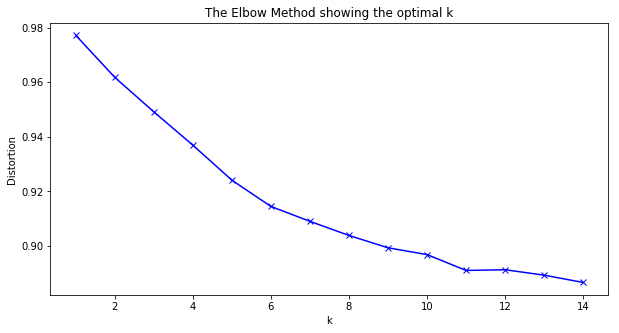

In [29]:
# Size of graph
plt.rcParams['figure.figsize'] = [10,5]

# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_train_tfidf)
    kmeanModel.fit(X_train_tfidf)
    distortions.append(sum(np.min(cdist(X_train_tfidf, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_train_tfidf.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [30]:
# Calulate predicted values
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42, n_init=20)
y_pred = kmeans.fit_predict(X_train_tfidf)

pd.crosstab(y_train_tfidf, y_pred)

col_0,0,1,2,3,4,5
airline_sentiment,,,,,,
-1,1453,991,1198,2014,1975,2243
0,800,1020,939,508,447,397
1,627,882,695,368,354,288


In [31]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_train_tfidf, y_pred)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(X_train_tfidf, y_pred, sample_size=60000, metric='euclidean')))

Adjusted Rand Score: 0.02853604
Silhouette Score: 0.07088227


# Modelling Phase

So, the tweets have been parsed and prepared for our models. We're trying to determine if it's possible to predict sentiment (a binary variable) so that means that we will require some classification models. As for which models to test, we will be using 
* Logistic Regression (a fast and simple model)
* Random Forest Ensemble (a powerful and scaleable model)
* Gradient Boosting Ensemble (a powerful, iterable model)

These three models differ fundamentally in how they operate, and range from least to most complex, meaning that logistic regression will almost always take the least amount of time, but gradient boosting will likely be the most accurate. 

In [32]:
# Create dataframe to track runtime and scores
models = ['Logistic regression' , 'Random forest', 'Gradient Boosting', 'Neural Networks']
runtime = []
train_score = []
test_score = []

In [33]:
def run_model(model):
    
    # Train the model
    train_set = cross_val_score(model, X_train_tfidf, y_train_tfidf, cv=5, n_jobs=-1)
    
    # Test the model
    start_time = timeit.default_timer()
    test_set = cross_val_score(model, X_test_tfidf, y_test_tfidf, cv=5, n_jobs=-1)
    elapsed_time = timeit.default_timer() - start_time
    
    # Append the score and runtime to our dataframe
    train_score.append(train_set.mean())
    test_score.append(test_set.mean())
    runtime.append(elapsed_time)
    
    # Fit the model to the data
    model.fit(X_train_tfidf, y_train_tfidf)
    
    # Store the predicted values in a dataframe
    y_pred = model.predict(X_test_tfidf)
    
    # Print scores and runtime
    print(str(model), '\n\nTrain score: {:.5f}(+/- {:.2f})\n'.format(train_set.mean(), train_set.std()*2))
    print('Test score: {:.5f}(+/- {:.2f})\n'.format(test_set.mean(), test_set.std()*2))
    print('Runtime:', elapsed_time, 'seconds\n')
    
    # Generate and print the confusion matrix
    print('Confusion matrix:\n\n', confusion_matrix(y_test_tfidf, y_pred))
    
    # Print the model's statisitcs
    print('\nClassification Report:\n\n' + classification_report(y_test_tfidf, y_pred))

In [34]:
# Logistic regression model
lr = LogisticRegression()
run_model(lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Train score: 0.74795(+/- 0.02)

Test score: 0.72667(+/- 0.02)

Runtime: 9.944499506 seconds

Confusion matrix:

 [[2909  270  102]
 [ 554  739  113]
 [ 276  176  594]]

Classification Report:

             precision    recall  f1-score   support

         -1       0.78      0.89      0.83      3281
          0       0.62      0.53      0.57      1406
          1       0.73      0.57      0.64      1046

avg / total       0.73      0.74      0.73      5733



In [35]:
# Random forest model
rfc = ensemble.RandomForestClassifier(n_jobs=-1)
run_model(rfc)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 

Train score: 0.83656(+/- 0.01)

Test score: 0.76191(+/- 0.02)

Runtime: 10.219324263999965 seconds

Confusion matrix:

 [[3051  160   70]
 [ 306 1032   68]
 [ 140  118  788]]

Classification Report:

             precision    recall  f1-score   support

         -1       0.87      0.93      0.90      3281
          0       0.79      0.73      0.76      1406
          1       0.85      0.75      0.80      1046

avg / total       0.85      0.85      0.85      5733



In [36]:
# Gradient Boosting Model
gbc = ensemble.GradientBoostingClassifier()
run_model(gbc)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False) 

Train score: 0.74888(+/- 0.01)

Test score: 0.73155(+/- 0.02)

Runtime: 15.334319463000043 seconds

Confusion matrix:

 [[3040  155   86]
 [ 703  605   98]
 [ 305  155  586]]

Classification Report:

             precision    recall  f1-score   support

         -1       0.75      0.93      0.83      3281
          0       0.66      0.43      0.52      1406
          1       0.76      0.56      0.65      1046

avg / total       0.73      0.74      0.72      5733



In [37]:
# Neural Network Model
mlp = MLPClassifier(hidden_layer_sizes=(100,10))
run_model(mlp)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False) 

Train score: 0.83325(+/- 0.01)

Test score: 0.76766(+/- 0.03)

Runtime: 31.821064033000084 seconds

Confusion matrix:

 [[2861  332   88]
 [ 179 1172   55]
 [ 105  166  775]]

Classification Report:

             precision    recall  f1-score   support

         -1       0.91      0.87      0.89      3281
          0       0.70      0.83      0.76      1406
          1       0.84      0.74      0.79      1046

avg / total       0.85      0.84      0.84      5733



In [38]:
# Create dataframes for the models and the scores
results = pd.DataFrame({'Model': models,
                        'Train score': train_score,
                        'Test score': test_score,
                        'Runtime': runtime})

# Print out the results
print('Scores: \n', results, '\n')

Scores: 
                  Model  Train score  Test score    Runtime
0  Logistic regression     0.747952    0.726670   9.944500
1        Random forest     0.836561    0.761911  10.219324
2    Gradient Boosting     0.748881    0.731551  15.334319
3      Neural Networks     0.833247    0.767661  31.821064 



### Model Comparison

So, after running all 4 types of models it seems as though ___ is the most accurate, and ___ has the longest runtime. Since ___ has the best accuracy, let's see if we can fine tune the parameters using GridSearchCV to get the best model.

In [39]:
# Setting up grid search to return the best results for the random forest model
param_grid = {'max_features': ['sqrt'],
              'n_estimators' : [10, 20, 40, 60],
              'max_depth' : [12, 20, 40],
              'min_samples_leaf' : [4, 8]}

# Run grid search to find ideal parameters
rfc_grid = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-2)

rfc_grid.fit(X_train_tfidf, y_train_tfidf)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'max_features': ['sqrt'], 'n_estimators': [10, 20, 40, 60], 'max_depth': [12, 20, 40], 'min_samples_leaf': [4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [40]:
# Run the random forest with the 'optimized' parameters
rfc_2 = ensemble.RandomForestClassifier(**rfc_grid.best_params_)
run_model(rfc_2)
models.append('Random forest (Optimized)')

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 

Train score: 0.76458(+/- 0.01)

Test score: 0.72841(+/- 0.01)

Runtime: 9.577428551000025 seconds

Confusion matrix:

 [[3046  151   84]
 [ 606  718   82]
 [ 259  155  632]]

Classification Report:

             precision    recall  f1-score   support

         -1       0.78      0.93      0.85      3281
          0       0.70      0.51      0.59      1406
          1       0.79      0.60      0.69      1046

avg / total       0.76      0.77      0.75      5733



In [47]:
# Create dataframes for the models and the scores
results = pd.DataFrame({'Model': models,
                        'Train_score': train_score,
                        'Test_score': test_score,
                        'Runtime': runtime})

# Print out the results
print('Scores: \n', results, '\n')

Scores: 
                        Model  Train_score  Test_score    Runtime
0        Logistic regression     0.747952    0.726670   9.944500
1              Random forest     0.836561    0.761911  10.219324
2          Gradient Boosting     0.748881    0.731551  15.334319
3            Neural Networks     0.833247    0.767661  31.821064
4  Random forest (Optimized)     0.764580    0.728411   9.577429 



In [50]:
# (Heavily consider separating the two later)

trace1 = go.Bar(
    x = results.Model,
    y = results.Test_score,
    name = 'Test Score'
)

trace2 = go.Bar(
    x = results.Model,
    y = results.Runtime,
    name = 'Runtime'
)

data = [trace1, trace2]
layout = go.Layout(
    title = 'Results',
    barmode = 'group'
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig, filename='stacked-bar')

# Testing Set

Now, it's time to add our testing data set. What if we decide to look at more recent tweets from the same airline, or how about we also decide to look at other airlines that weren't even in our dataset? 

Enough with the hypotheticals. The next dataset is a collection of recent tweets containing the testing data that we want and while we won't be able to assess its accuracy since we don't have the correct values, we should be able to get a good idea of measuring sentiment analysis for more recent tweets targetting the airlines in our dataset, as well as other airlines that actually aren't in our model. 

What this will demonstrate is how useful our models are for predicting sentiment analysis for tweets that our model has not seen yet.

In [ ]:
# Import the training dataset
tweets_test = pd.read_csv("airline_tweets/test_set.csv")

# Preview the data
tweets_test.head()